# TEXT PREPROCESSING AND SENTIMENT ANALYSIS

## Importing the required Libraries

In [1]:
import pandas as pd
import json
import gzip
import re
import spacy                                                 
from spacy.lang.en import English                             # Import specific model
nlp = spacy.load("en_core_web_sm")                            # Load model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import recall_score,precision_score,accuracy_score,f1_score,classification_report,plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Loading the Datafile which we used for EDA

In [2]:
df_final=pd.read_csv("finally_done.csv")
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8
2,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4
3,2017-03-27,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,3
4,2017-02-28,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,2


## Checking the shape of our dataframe

In [3]:
df_final.shape

(21272, 14)

## Defining functions for modular coding purpose

In [4]:
def null_values(df):
    print(f"Total null values with repect too each column are:- {df.isnull().sum()}")

In [5]:
def per_null(df,col):
    null=df[col].isnull().sum()
    total=len(df)
    percent=(null/total)*100
    print(f"Percentage of null values are {round(percent,2)}")

In [6]:
def val_count(df,col):
    print(f"Counts of each category are {df[col].value_counts()}")

In [7]:
def n_unq(df,col):
    print(f"No. of unique values are {df[col].nunique()}")

## We are removing some words from the stopwords so that we can proceed further for the sentiment analysis

In [8]:
nlp.Defaults.stop_words-={'against','cannot','bottom','except','least','less','never','none','Noone','no','nobody','nothing','nor',"n't"}

## For the text preprocessing we are combining the summary and review

In [9]:
df_final['final_review']=df_final['reviewText']+' '+df_final['summary']

## We are doing the contraction for some words for stopwords

In [10]:
contract = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have"}


In [11]:
def cont_to_exp(x):
    if x in contract.keys():
        value=contract[x]
    else:
        value=x
    return value

In [12]:
df_final.head(2)

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,This handcream has a beautiful fragrance. It d...
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,There is no evidence to me that this product i...


## Defining and performing functions for cleaning the texts,Lemmatization and text preprocessing part

In [13]:
def clean_text(text):
    """
    Return clean version of the text
    """
    text = text.lower()
    text = ' '.join(list((cont_to_exp(t) for t in text.split())))    
    # Remove all non-letters and non-spaces except for hyphens and digits
    text = re.sub("[^0-9A-Za-z\- ]+", " ", text)
    # Remove all numbers except those attached to a word
    text = re.sub("(?<!\w)\d+", "", text)
    # Remove all hyphens except between two words
    text = re.sub("-(?!\w)|(?<!\w)-", "", text)
    #Remove all Urls
    text=re.sub('http\S+','_URL_ ', text)
    # Remove multiple spaces
    text = " ".join(text.split())
    

    return text

df_final['final_review'] = df_final['final_review'].apply(clean_text)
print(df_final['final_review'][:5])

0    this handcream has a beautiful fragrance it do...
1    there is no evidence to me that this product i...
2    wonderful hand lotion for seriously dry skin s...
3    best hand cream around silky thick soaks in al...
4    great hand lotion soaks right in and leaves sk...
Name: final_review, dtype: object


# Performing the classification and doing the evaluation for different classification models

In [14]:
from nltk.corpus import stopwords
stop_words_nltk = stopwords.words('english')

In [15]:
stop_words_nltk.remove('not')

In [16]:
l=['once','not','no','nor',"don't","couldn't","aren't","didn't","shouldn't","doesn't","hadn't","hasn't","haven't","isn't","mustn't","wasn't","wouldn't"]

In [17]:
for i in l:
    if i in stop_words_nltk:
        stop_words_nltk.remove(i)

In [18]:
stop_words_nltk

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few'

In [19]:
len(stop_words_nltk)

162

In [20]:
for i in range(len(df_final['final_review'])):
    doc=nlp(str(df_final['final_review'][i]))
    filt=[]
    for word in doc:
        if word.is_stop==False:                                               
            filt.append(word.lemma_)
    df_final['final_review'][i]=" ".join(filt) 
df_final['final_review'][:5]

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\1781671299.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['final_review'][i]=" ".join(filt)


0    handcream beautiful fragrance not stay protect...
1    no evidence product improvement similarly pric...
2    wonderful hand lotion seriously dry skin stay ...
3    good hand cream silky thick soak way leave han...
4    great hand lotion soak right leave skin super ...
Name: final_review, dtype: object

### Clasification Using Polarity

In [21]:
from textblob import TextBlob
df_final['polarity']=df_final['final_review'].apply( lambda x : TextBlob(x).sentiment.polarity)
df_final['polarity']

0        0.483333
1       -0.083333
2        0.346250
3        0.306667
4        0.519841
           ...   
21267    0.243673
21268    0.174956
21269   -0.042727
21270    0.343265
21271    0.218182
Name: polarity, Length: 21272, dtype: float64

In [22]:
df_final.loc[(df_final["polarity"] > 0) , 'blobsentiment'] = 'Positive'
df_final.loc[(df_final["polarity"] == 0) , 'blobsentiment'] = 'Neutral'
df_final.loc[(df_final["polarity"] < 0) , 'blobsentiment'] = 'Negative'

In [66]:
df_final.to_csv('abc.csv',index=False)

In [23]:
df_final_dup=df_final.copy()

<AxesSubplot:xlabel='polarity', ylabel='Count'>

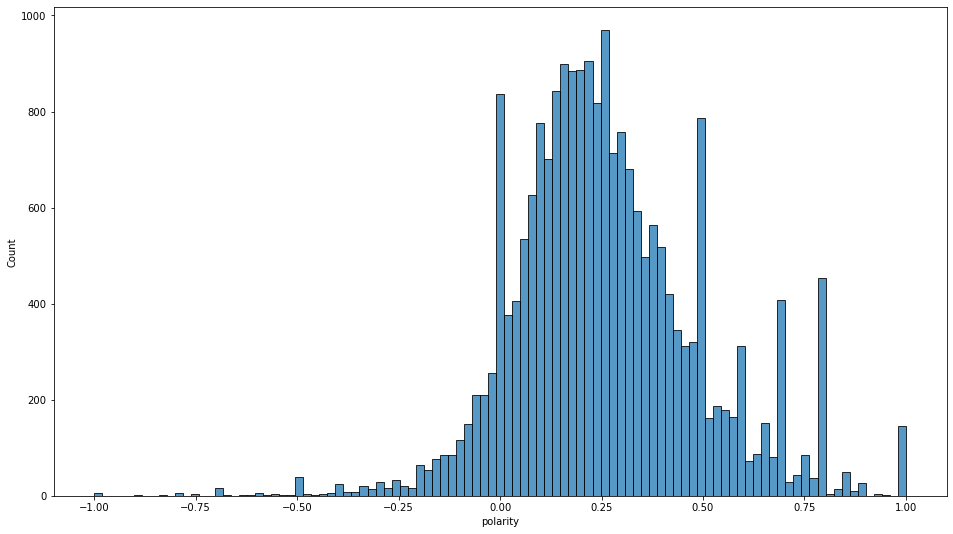

In [210]:
import seaborn as sns
plt.figure(figsize=(16,9))
sns.histplot(data=df_final,x='polarity')

In [211]:
len(df_final['polarity'])

21272

In [213]:
len(df_final[df_final['polarity']<0])

1692

In [214]:
len(df_final[df_final['polarity']==0])

591

In [215]:
len(df_final[df_final['polarity']>0])

18989

In [24]:
df_final_dup.reset_index(inplace=True)
dataset = df_final_dup[['final_review', 'blobsentiment']]
dataset.head(2)

,final_review,blobsentiment
0,handcream beautiful fragrance not stay protect...,Positive
1,no evidence product improvement similarly pric...,Negative


In [25]:
dataset['blobsentiment'].value_counts()/len(dataset)

Positive    0.892676
Negative    0.079541
Neutral     0.027783
Name: blobsentiment, dtype: float64

# to avoid a sampling bias we'll augment the reviews by oversampling. After oversampling we'll split the dataset into test and train using stratified sampling with the StratifiedShuffleSplit module in sklearn

# lets check the distribution of data on the test data and see if the representation of the target variable is the close to the original sample

#### Splittig the data into train|test

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit
split= StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) 
for train_index, test_index in split.split(dataset, dataset['blobsentiment']):
    strat_train_set = dataset.iloc[train_index]
    strat_test_set = dataset.iloc[test_index]

In [27]:
strat_test_set['blobsentiment'].value_counts()/len(strat_test_set)

Positive    0.892597
Negative    0.079671
Neutral     0.027732
Name: blobsentiment, dtype: float64

In [28]:
strat_train_set['blobsentiment'].value_counts()/len(strat_train_set)

Positive    0.892696
Negative    0.079509
Neutral     0.027796
Name: blobsentiment, dtype: float64

In [29]:
#import necessary nltk libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from textaugment import Wordnet, Translate

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
t=Wordnet()
#test
sentence ='Hello, I have been so exhausted lately. I need to rest'
t.augment(sentence)

'hello, i bear live so exhausted lately. i demand to rest'

In [32]:
#augment reviews with sentiment not equal to positive
augmented = pd.DataFrame()
for i in strat_train_set[strat_train_set['blobsentiment'] != 'Positive'].index:
    text_aug = t.augment(str(strat_train_set['final_review'][i]))
    augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2134299286.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented = augmented.append({'final_review':text_aug ,'blobsentiment': dataset['blobsentiment'][i]} , ignore_index=True)
C:\Users\Asus\AppData\Local\Temp\i

In [33]:
import numpy as np

In [38]:
#drop 70% of records with scores equal to Positive and add augmented to train set

part_na = round(strat_train_set[strat_train_set['blobsentiment'] == 'Positive'].shape[0]*0.7)
strat_train_set.head()
five_indices = strat_train_set[strat_train_set.blobsentiment=='Positive' ].index
random_indices = np.random.choice(five_indices, part_na, replace= False)
random_indices 

array([17871, 13847,  6382, ..., 10862,  1081, 17300], dtype=int64)

In [39]:
strat_train_set.drop(random_indices, inplace = True)
strat_train_set['blobsentiment'].value_counts()/len(strat_train_set)

Negative    0.480312
Positive    0.355361
Neutral     0.164327
Name: blobsentiment, dtype: float64

In [40]:
#append augmented to strat_train_set
strat_train_set = strat_train_set.append(augmented)
strat_train_set['blobsentiment'].value_counts()/len(strat_train_set)

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\660701749.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strat_train_set = strat_train_set.append(augmented)


Negative    0.548735
Positive    0.262076
Neutral     0.189189
Name: blobsentiment, dtype: float64

# TF-IDF VECTORIZER

In [45]:
def funct(classifier,input_train,input_test,label_train,label_test):
    vectorizer=TfidfVectorizer(sublinear_tf=True,max_df=0.5,min_df=1,stop_words=stopwords.words('english'),use_idf=True,smooth_idf=True)
    X_train=vectorizer.fit_transform(input_train)
    X_test=vectorizer.transform(input_test)
    clf=classifier.fit(X_train,label_train)
    y_pred=clf.predict(X_test)
    plot_confusion_matrix(clf,X_test,label_test)
    print(classification_report(label_test,y_pred))
    print('accuracy:', accuracy_score(label_test, y_pred))
    print('recall:', recall_score(label_test, y_pred, average='weighted'))
    print('f1-score:', f1_score(label_test, y_pred,average='weighted'))
    print('precision:', precision_score(label_test, y_pred, average='weighted'))
    return label_test,y_pred,vectorizer

### (ii) Count Vectorizer with n grams

In [46]:
def funct_ngrams(classifier,input_train,input_test,label_train,label_test):
    vectorizer=CountVectorizer(ngram_range=(1,2))
    X_train=vectorizer.fit_transform(input_train)
    X_test=vectorizer.transform(input_test)
    clf=classifier.fit(X_train,label_train)
    y_pred=clf.predict(X_test)
    plot_confusion_matrix(clf,X_test,label_test)
    print(classification_report(label_test,y_pred))
    print('accuracy:', accuracy_score(label_test, y_pred))
    print('recall:', recall_score(label_test, y_pred, average='weighted'))
    print('f1-score:', f1_score(label_test, y_pred,average='weighted'))
    print('precision:', precision_score(label_test, y_pred, average='weighted'))
    return label_test,y_pred,vectorizer

In [41]:
from sklearn.naive_bayes import MultinomialNB

# Vectorization technique used in below models is TF-IDF

# Multinomial Naviye Bayes

In [42]:
model_1=MultinomialNB()

In [50]:
X_train=strat_train_set['final_review']
X_test=strat_test_set['final_review']
y_train=strat_train_set['blobsentiment']
y_test=strat_test_set['blobsentiment']

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.11      1.00      0.20       339
     Neutral       0.81      0.33      0.47       118
    Positive       1.00      0.31      0.48      3798

    accuracy                           0.37      4255
   macro avg       0.64      0.55      0.38      4255
weighted avg       0.92      0.37      0.46      4255

accuracy: 0.36944770857814335
recall: 0.36944770857814335
f1-score: 0.45628157402863706
precision: 0.9233264116733769


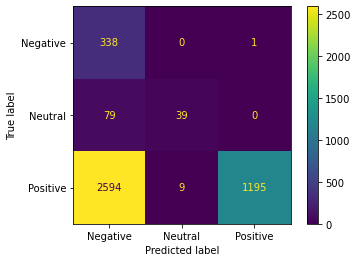

In [47]:
actual_1,predicted_1,vect_1=funct(model_1,strat_train_set['final_review'],strat_test_set['final_review'],strat_train_set['blobsentiment'],strat_test_set['blobsentiment'])

In [48]:
accuracy_1=[]
recall_1=[]
precision_1=[]
f1score_1=[]
model_name_1=[]

In [49]:
accuracy_1.append(accuracy_score(actual_1,predicted_1))
recall_1.append(recall_score(actual_1,predicted_1,average='weighted'))
precision_1.append(precision_score(actual_1,predicted_1,average='weighted'))
f1score_1.append(f1_score(actual_1,predicted_1,average='weighted'))
model_name_1.append('Multinomial Naviye bayes with TF-IDF VECTORIZER')

# Logistic Regression with One Vs Rest Classifier

In [51]:
lr_2 = LogisticRegression(max_iter=200, verbose=1)
ovr_2 = OneVsRestClassifier(lr_2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.28      0.94      0.44       339
     Neutral       0.51      0.71      0.59       118
    Positive       1.00      0.78      0.87      3798

    accuracy                           0.79      4255
   macro avg       0.60      0.81      0.63      4255
weighted avg       0.93      0.79      0.83      4255

accuracy: 0.7889541715628672
recall: 0.7889541715628672
f1-score: 0.8309285750273872
precision: 0.9262594086474731


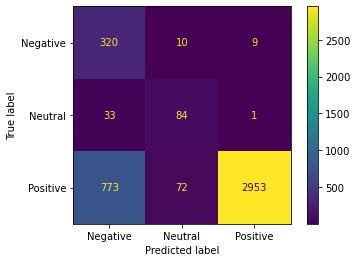

In [52]:
actual_2,predicted_2,vect_2=funct(ovr_2,X_train,X_test,y_train,y_test)

In [53]:
accuracy_1.append(accuracy_score(actual_2,predicted_2))
recall_1.append(recall_score(actual_2,predicted_2,average='weighted'))
precision_1.append(precision_score(actual_2,predicted_2,average='weighted'))
f1score_1.append(f1_score(actual_2,predicted_2,average='weighted'))
model_name_1.append('Logistic Regression (One Vs Rest Classifier) with TF-IDF VECTORIZER')

# Decission Tree Classifier

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
params = {'max_depth': [2,3,5,10,20],
    'max_leaf_nodes': [5,6,7,8,9,10]}

In [56]:
classif_3=DecisionTreeClassifier()

In [57]:
grid_3 = GridSearchCV(estimator=classif_3, param_grid=params,cv = 5,n_jobs=-1, scoring="accuracy")

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.18      0.80      0.30       339
     Neutral       0.26      0.57      0.35       118
    Positive       0.98      0.65      0.78      3798

    accuracy                           0.66      4255
   macro avg       0.47      0.67      0.48      4255
weighted avg       0.90      0.66      0.73      4255

accuracy: 0.6594594594594595
recall: 0.6594594594594595
f1-score: 0.7309855111375473
precision: 0.8963364519893853


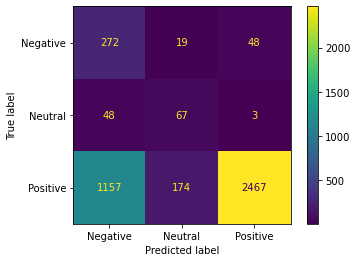

In [58]:
actual_3,predicted_3,vect_3=funct(grid_3,X_train,X_test,y_train,y_test)

In [59]:
accuracy_1.append(accuracy_score(actual_3,predicted_3))
recall_1.append(recall_score(actual_3,predicted_3,average='weighted'))
precision_1.append(precision_score(actual_3,predicted_3,average='weighted'))
f1score_1.append(f1_score(actual_3,predicted_3,average='weighted'))
model_name_1.append('Decision tree classifier with TF-IDF VECTORIZER')

# Random Forest using Grid Search CV

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [62]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [63]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

Fitting 4 folds for each of 180 candidates, totalling 720 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.12      0.98      0.21       339
     Neutral       0.22      0.49      0.30       118
    Positive       1.00      0.29      0.45      3798

    accuracy                           0.35      4255
   macro avg       0.44      0.59      0.32      4255
weighted avg       0.91      0.35      0.42      4255

accuracy: 0.34947121034077555
recall: 0.34947121034077555
f1-score: 0.42450820508598175
precision: 0.907003851027048


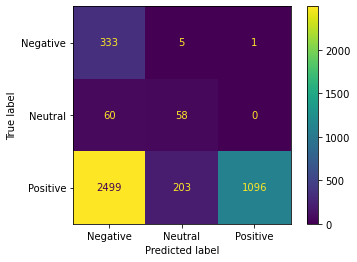

In [64]:
actual_4,predicted_4,vect_4=funct(grid_search,X_train,X_test,y_train,y_test)

In [65]:
accuracy_1.append(accuracy_score(actual_4,predicted_4))
recall_1.append(recall_score(actual_4,predicted_4,average='weighted'))
precision_1.append(precision_score(actual_4,predicted_4,average='weighted'))
f1score_1.append(f1_score(actual_4,predicted_4,average='weighted'))
model_name_1.append('Random Forest Classifier with TF-IDF VECTORIZER')

# Vectorization technique used in below models is Count-Vectorizer with n-grams (1,2)

# Multinomial Naviye Bayes

In [79]:
model_5=MultinomialNB()

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.23      0.87      0.36       339
     Neutral       0.78      0.43      0.56       118
    Positive       0.98      0.75      0.85      3798

    accuracy                           0.75      4255
   macro avg       0.66      0.68      0.59      4255
weighted avg       0.91      0.75      0.80      4255

accuracy: 0.7508813160987075
recall: 0.7508813160987075
f1-score: 0.803051091397022
precision: 0.9148240125620071


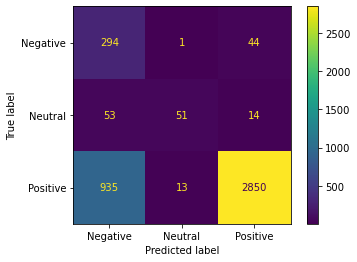

In [80]:
actual_5,predicted_5,vect_5=funct_ngrams(model_5,X_train,X_test,y_train,y_test)

In [81]:
accuracy_1.append(accuracy_score(actual_5,predicted_5))
recall_1.append(recall_score(actual_5,predicted_5,average='weighted'))
precision_1.append(precision_score(actual_5,predicted_5,average='weighted'))
f1score_1.append(f1_score(actual_5,predicted_5,average='weighted'))
model_name_1.append('Multinomial Naviye bayes with Count Vectorizer')

# Logistic Regression with One Vs Rest Classifier

In [82]:
lr_6 = LogisticRegression(max_iter=200, verbose=1)
ovr_6 = OneVsRestClassifier(lr_6)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.40      0.86      0.55       339
     Neutral       0.39      0.90      0.54       118
    Positive       0.99      0.85      0.92      3798

    accuracy                           0.85      4255
   macro avg       0.60      0.87      0.67      4255
weighted avg       0.93      0.85      0.88      4255

accuracy: 0.8528789659224442
recall: 0.8528789659224442
f1-score: 0.8764527134225385
precision: 0.9288383249232574


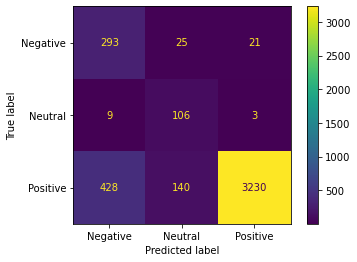

In [83]:
actual_6,predicted_6,vect_6=funct_ngrams(ovr_6,X_train,X_test,y_train,y_test)

In [84]:
accuracy_1.append(accuracy_score(actual_6,predicted_6))
recall_1.append(recall_score(actual_6,predicted_6,average='weighted'))
precision_1.append(precision_score(actual_6,predicted_6,average='weighted'))
f1score_1.append(f1_score(actual_6,predicted_6,average='weighted'))
model_name_1.append('Logestic Regression with One Vs Rest Classifier with Count Vectorizer')

# Decission Tree Classifier

In [85]:
params = {'max_depth': [2,3,5,10,20],
    'max_leaf_nodes': [5,6,7,8,9,10]}

In [86]:
classif_7=DecisionTreeClassifier()

In [87]:
grid_7 = GridSearchCV(estimator=classif_7, param_grid=params,cv = 5,n_jobs=-1, scoring="accuracy")

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.19      0.77      0.30       339
     Neutral       0.22      0.64      0.33       118
    Positive       0.98      0.65      0.78      3798

    accuracy                           0.66      4255
   macro avg       0.46      0.69      0.47      4255
weighted avg       0.90      0.66      0.73      4255

accuracy: 0.6578143360752057
recall: 0.6578143360752057
f1-score: 0.7297240612972343
precision: 0.896203862872013


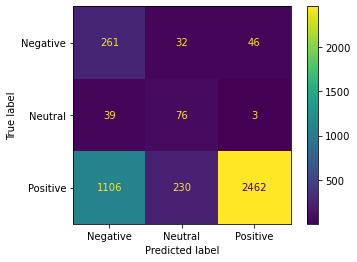

In [88]:
actual_7,predicted_7,vect_7=funct_ngrams(grid_7,X_train,X_test,y_train,y_test)

In [ ]:
accuracy_1.append(accuracy_score(actual_7,predicted_7))
recall_1.append(recall_score(actual_7,predicted_7,average='weighted'))
precision_1.append(precision_score(actual_7,predicted_7,average='weighted'))
f1score_1.append(f1_score(actual_7,predicted_7,average='weighted'))
model_name_1.append('Decision tree classifier with Count vectorizer VECTORIZER')

# Random Forest using Grid Search CV

In [89]:
rf_8 = RandomForestClassifier(random_state=42, n_jobs=-1)

In [90]:
params_8 = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [91]:
grid_search_8 = GridSearchCV(estimator=rf_8,
                           param_grid=params_8,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

Fitting 4 folds for each of 180 candidates, totalling 720 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.09      1.00      0.16       339
     Neutral       0.67      0.02      0.03       118
    Positive       1.00      0.09      0.17      3798

    accuracy                           0.16      4255
   macro avg       0.58      0.37      0.12      4255
weighted avg       0.92      0.16      0.16      4255

accuracy: 0.16051703877790835
recall: 0.16051703877790835
f1-score: 0.16143041446967737
precision: 0.9153809226078602


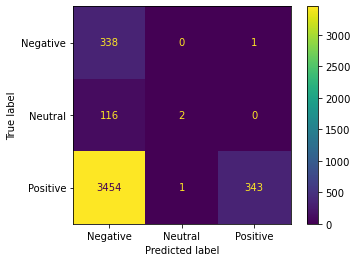

In [92]:
actual_8,predicted_8,vect_8=funct_ngrams(grid_search_8,X_train,X_test,y_train,y_test)

In [93]:
accuracy_1.append(accuracy_score(actual_8,predicted_8))
recall_1.append(recall_score(actual_8,predicted_8,average='weighted'))
precision_1.append(precision_score(actual_8,predicted_8,average='weighted'))
f1score_1.append(f1_score(actual_8,predicted_8,average='weighted'))
model_name_1.append('Random Forest Classifier with COUNT VECTORIZER')

In [96]:
df_comparision=pd.DataFrame({"model name":model_name_1,"accuracy":accuracy_1,"recall":recall_1,"precision":precision_1,"f1-score":f1score_1})

,model name,accuracy,recall,precision,f1-score
0,Multinomial Naviye bayes with TF-IDF VECTORIZER,0.369448,0.369448,0.923326,0.456282
1,Logistic Regression (One Vs Rest Classifier) w...,0.788954,0.788954,0.926259,0.830929
2,Decision tree classifier with TF-IDF VECTORIZER,0.659459,0.659459,0.896336,0.730986
3,Random Forest Classifier with TF-IDF VECTORIZER,0.349471,0.349471,0.907004,0.424508
4,Multinomial Naviye bayes with Count Vectorizer,0.369448,0.369448,0.923326,0.456282
5,Logestic Regression with One Vs Rest Classifie...,0.788954,0.788954,0.926259,0.830929
6,Multinomial Naviye bayes with Count Vectorizer,0.750881,0.750881,0.914824,0.803051
7,Logestic Regression with One Vs Rest Classifie...,0.852879,0.852879,0.928838,0.876453
8,Random Forest Classifier with COUNT VECTORIZER,0.160517,0.160517,0.915381,0.161430


In [98]:
df_comparision

,model name,accuracy,recall,precision,f1-score
0,Multinomial Naviye bayes with TF-IDF VECTORIZER,0.369448,0.369448,0.923326,0.456282
1,Logistic Regression (One Vs Rest Classifier) w...,0.788954,0.788954,0.926259,0.830929
2,Decision tree classifier with TF-IDF VECTORIZER,0.659459,0.659459,0.896336,0.730986
3,Random Forest Classifier with TF-IDF VECTORIZER,0.349471,0.349471,0.907004,0.424508
5,Logestic Regression with One Vs Rest Classifie...,0.788954,0.788954,0.926259,0.830929
6,Multinomial Naviye bayes with Count Vectorizer,0.750881,0.750881,0.914824,0.803051
7,Logestic Regression with One Vs Rest Classifie...,0.852879,0.852879,0.928838,0.876453
8,Random Forest Classifier with COUNT VECTORIZER,0.160517,0.160517,0.915381,0.161430


# Logistic regression with One Vs Rest Classifier (using Count Vectorizer n-grams 1,2) is having highest accuracy

# Without Text Augumentation

# Vectorization technique used in the below two models is TF-IDF

# Multinomial Naviye Bayes

In [99]:
model_sb=MultinomialNB()

In [100]:
X_f=df_final['final_review']

In [101]:
y_i=df_final['blobsentiment']

## Train|Test Splitting

In [102]:
input_train_1,input_test_1,label_train_1,label_test_1=train_test_split(X_f, y_i, test_size=0.30, random_state=42)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       494
     Neutral       0.00      0.00      0.00       172
    Positive       0.90      1.00      0.94      5716

    accuracy                           0.90      6382
   macro avg       0.30      0.33      0.31      6382
weighted avg       0.80      0.90      0.85      6382

accuracy: 0.8953306173613287
recall: 0.8953306173613287
f1-score: 0.8461821773871289
precision: 0.8021488728585197


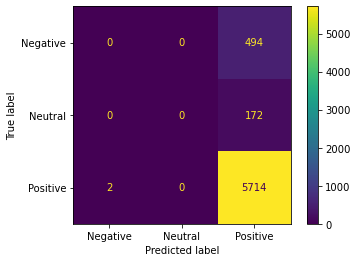

In [103]:
actual_sb,predicted_sb,vect_sb=funct(model_sb,input_train_1,input_test_1,label_train_1,label_test_1)

In [104]:
accuracy_sb=[]
recall_sb=[]
precision_sb=[]
f1score_sb=[]
model_name_sb=[]

In [105]:
accuracy_sb.append(accuracy_score(actual_sb,predicted_sb))
recall_sb.append(recall_score(actual_sb,predicted_sb,average='weighted'))
precision_sb.append(precision_score(actual_sb,predicted_sb,average='weighted'))
f1score_sb.append(f1_score(actual_sb,predicted_sb,average='weighted'))
model_name_sb.append('Multinomial Naviye bayes with TF-IDF VECTORIZER')

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

In [106]:
lr_sb = LogisticRegression(max_iter=200, verbose=1)
ovr_sb = OneVsRestClassifier(lr_sb)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       1.00      0.16      0.28       494
     Neutral       1.00      0.40      0.57       172
    Positive       0.92      1.00      0.96      5716

    accuracy                           0.92      6382
   macro avg       0.97      0.52      0.60      6382
weighted avg       0.93      0.92      0.89      6382

accuracy: 0.9191476026324036
recall: 0.9191476026324036
f1-score: 0.894204174274227
precision: 0.92584205658646


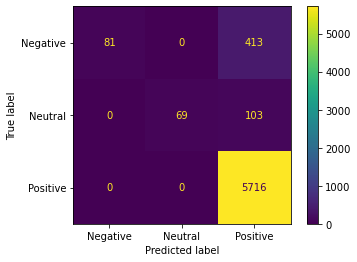

In [107]:
actual_dup,predicted_dup,vect_dup=funct(ovr_sb,input_train_1,input_test_1,label_train_1,label_test_1)

In [108]:
accuracy_sb.append(accuracy_score(actual_dup,predicted_dup))
recall_sb.append(recall_score(actual_dup,predicted_dup,average='weighted'))
precision_sb.append(precision_score(actual_dup,predicted_dup,average='weighted'))
f1score_sb.append(f1_score(actual_dup,predicted_dup,average='weighted'))
model_name_sb.append('Logistic Regression with TF-IDF VECTORIZER')

# Decision Tree Classifier

In [109]:
params = {'max_depth': [2,3,5,10,20],
    'max_leaf_nodes': [5,6,7,8,9,10]}

In [110]:
classif_sb_1=DecisionTreeClassifier()

In [111]:
grid_sb_1 = GridSearchCV(estimator=classif_sb_1, param_grid=params,cv = 5,n_jobs=-1, scoring="accuracy")

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00       494
     Neutral       1.00      0.12      0.21       172
    Positive       0.90      1.00      0.95      5716

    accuracy                           0.90      6382
   macro avg       0.97      0.37      0.39      6382
weighted avg       0.91      0.90      0.85      6382

accuracy: 0.8989345032905045
recall: 0.8989345032905045
f1-score: 0.8537375663101475
precision: 0.90918245886001


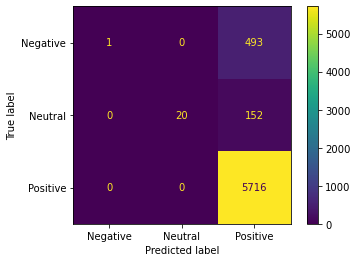

In [112]:
actual_sb_1,predicted_sb_1,vect_sb_1=funct(grid_sb_1,input_train_1,input_test_1,label_train_1,label_test_1)

In [113]:
accuracy_sb.append(accuracy_score(actual_sb_1,predicted_sb_1))
recall_sb.append(recall_score(actual_sb_1,predicted_sb_1,average='weighted'))
precision_sb.append(precision_score(actual_sb_1,predicted_sb_1,average='weighted'))
f1score_sb.append(f1_score(actual_sb_1,predicted_sb_1,average='weighted'))
model_name_sb.append('Decision tree classifier with TF-IDF VECTORIZER')

# Random Forest Classifier with Grid Search CV

In [114]:
rf_sb = RandomForestClassifier(random_state=42, n_jobs=-1)

In [115]:
params_sb = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [116]:
grid_search_sb_2 = GridSearchCV(estimator=rf_8,
                           param_grid=params_8,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

Fitting 4 folds for each of 180 candidates, totalling 720 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       494
     Neutral       0.00      0.00      0.00       172
    Positive       0.90      1.00      0.94      5716

    accuracy                           0.90      6382
   macro avg       0.30      0.33      0.31      6382
weighted avg       0.80      0.90      0.85      6382

accuracy: 0.8956439987464745
recall: 0.8956439987464745
f1-score: 0.8463384190502311
precision: 0.8021781724905748


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


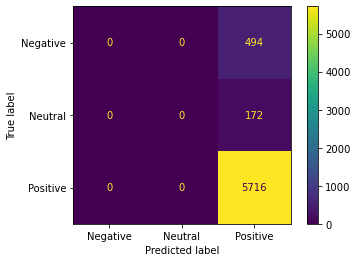

In [120]:
actual_sb_2,predicted_sb_2,vect_sb_2=funct_ngrams(grid_search_sb_2,input_train_1,input_test_1,label_train_1,label_test_1)

In [121]:
accuracy_sb.append(accuracy_score(actual_sb_2,predicted_sb_2))
recall_sb.append(recall_score(actual_sb_2,predicted_sb_2,average='weighted'))
precision_sb.append(precision_score(actual_sb_2,predicted_sb_2,average='weighted'))
f1score_sb.append(f1_score(actual_sb_2,predicted_sb_2,average='weighted'))
model_name_sb.append('Random Forest Classifier with TF-IDF VECTORIZER')

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# With count vectorizer ngrams

# Logistic Regression with One Vs Rest Classifier

In [122]:
lr_bs_1 = LogisticRegression(max_iter=200, verbose=1)
ovr_bs_1 = OneVsRestClassifier(lr_bs_1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       0.81      0.56      0.67       494
     Neutral       0.85      0.71      0.77       172
    Positive       0.96      0.99      0.97      5716

    accuracy                           0.95      6382
   macro avg       0.87      0.75      0.80      6382
weighted avg       0.94      0.95      0.94      6382

accuracy: 0.94797869006581
recall: 0.94797869006581
f1-score: 0.9438602956188299
precision: 0.9440423263598573


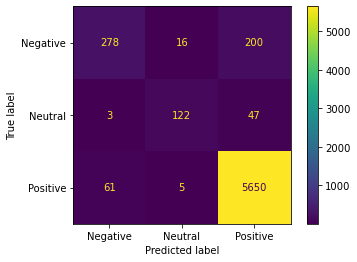

In [123]:
actual_bs_1,predicted_bs_1,vect_bs_1=funct_ngrams(ovr_bs_1,input_train_1,input_test_1,label_train_1,label_test_1)

In [124]:
accuracy_sb.append(accuracy_score(actual_bs_1,predicted_bs_1))
recall_sb.append(recall_score(actual_bs_1,predicted_bs_1,average='weighted'))
precision_sb.append(precision_score(actual_bs_1,predicted_bs_1,average='weighted'))
f1score_sb.append(f1_score(actual_bs_1,predicted_bs_1,average='weighted'))
model_name_sb.append('Logistic Regression with COUNT VECTORIZER n-grams(1,2)')

# Multinomial Naviye Bayes

In [125]:
model_bs_2=MultinomialNB()

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       494
     Neutral       0.00      0.00      0.00       172
    Positive       0.90      1.00      0.94      5716

    accuracy                           0.90      6382
   macro avg       0.30      0.33      0.31      6382
weighted avg       0.80      0.90      0.85      6382

accuracy: 0.8953306173613287
recall: 0.8953306173613287
f1-score: 0.8461821773871289
precision: 0.8021488728585197


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


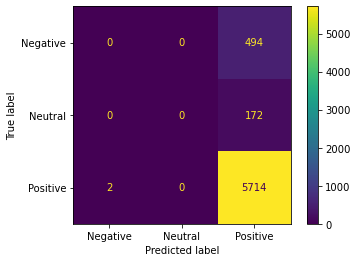

In [126]:
actual_bs_2,predicted_bs_2,vect_bs_2=funct(model_bs_2,input_train_1,input_test_1,label_train_1,label_test_1)

In [127]:
accuracy_sb.append(accuracy_score(actual_bs_2,predicted_bs_2))
recall_sb.append(recall_score(actual_bs_2,predicted_bs_2,average='weighted'))
precision_sb.append(precision_score(actual_bs_2,predicted_bs_2,average='weighted'))
f1score_sb.append(f1_score(actual_bs_2,predicted_bs_2,average='weighted'))
model_name_sb.append('Multinomial Naviye bayes with COUNT VECTORIZER n-grams(1,2)')

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decission Tree Classifier

In [128]:
params = {'max_depth': [2,3,5,10,20],
    'max_leaf_nodes': [5,6,7,8,9,10]}

In [129]:
classif_dec_bs=DecisionTreeClassifier()

In [130]:
grid_bs = GridSearchCV(estimator=classif_dec_bs, param_grid=params,cv = 5,n_jobs=-1, scoring="accuracy")

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00       494
     Neutral       1.00      0.12      0.21       172
    Positive       0.90      1.00      0.95      5716

    accuracy                           0.90      6382
   macro avg       0.97      0.37      0.39      6382
weighted avg       0.91      0.90      0.85      6382

accuracy: 0.8989345032905045
recall: 0.8989345032905045
f1-score: 0.8537375663101475
precision: 0.90918245886001


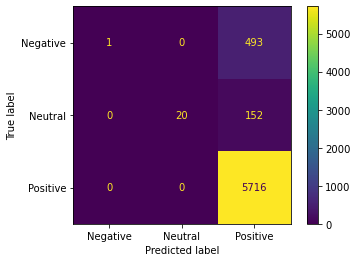

In [131]:
actual_bs_3,predicted_bs_3,vect_bs_3=funct(grid_bs,input_train_1,input_test_1,label_train_1,label_test_1)

In [132]:
accuracy_sb.append(accuracy_score(actual_bs_3,predicted_bs_3))
recall_sb.append(recall_score(actual_bs_3,predicted_bs_3,average='weighted'))
precision_sb.append(precision_score(actual_bs_3,predicted_bs_3,average='weighted'))
f1score_sb.append(f1_score(actual_bs_3,predicted_bs_3,average='weighted'))
model_name_sb.append('Decision tree classifier with COUNT VECTORIZER')

In [133]:
df_comparision_s=pd.DataFrame({"model name":model_name_sb,"accuracy":accuracy_sb,"recall":recall_sb,"precision":precision_sb,"f1-score":f1score_sb})


,model name,accuracy,recall,precision,f1-score
0,Multinomial Naviye bayes with TF-IDF VECTORIZER,0.895331,0.895331,0.802149,0.846182
1,Logistic Regression with TF-IDF VECTORIZER,0.919148,0.919148,0.925842,0.894204
2,Decision tree classifier with TF-IDF VECTORIZER,0.898935,0.898935,0.909182,0.853738
3,Random Forest Classifier with TF-IDF VECTORIZER,0.160517,0.160517,0.915381,0.161430
4,Random Forest Classifier with TF-IDF VECTORIZER,0.895644,0.895644,0.802178,0.846338
5,Logistic Regression with COUNT VECTORIZER n-gr...,0.947979,0.947979,0.944042,0.943860
6,Multinomial Naviye bayes with COUNT VECTORIZER...,0.895331,0.895331,0.802149,0.846182
7,Decision tree classifier with COUNT VECTORIZER,0.898935,0.898935,0.909182,0.853738


In [135]:
df_comparision_s

,model name,accuracy,recall,precision,f1-score
0,Multinomial Naviye bayes with TF-IDF VECTORIZER,0.895331,0.895331,0.802149,0.846182
1,Logistic Regression with TF-IDF VECTORIZER,0.919148,0.919148,0.925842,0.894204
2,Decision tree classifier with TF-IDF VECTORIZER,0.898935,0.898935,0.909182,0.853738
4,Random Forest Classifier with TF-IDF VECTORIZER,0.895644,0.895644,0.802178,0.846338
5,Logistic Regression with COUNT VECTORIZER n-gr...,0.947979,0.947979,0.944042,0.943860
6,Multinomial Naviye bayes with COUNT VECTORIZER...,0.895331,0.895331,0.802149,0.846182
7,Decision tree classifier with COUNT VECTORIZER,0.898935,0.898935,0.909182,0.853738


<AxesSubplot:title={'center':'f1 score as per models'}, ylabel='model name'>

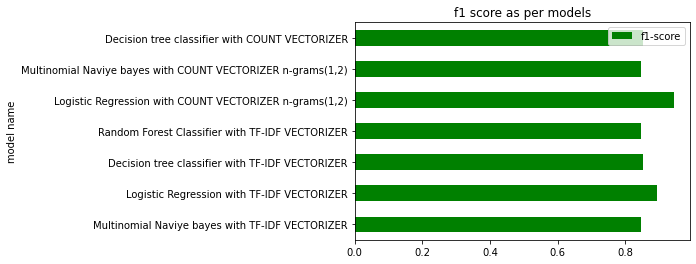

In [136]:
df_comparision_s.plot.barh(x='model name',y='f1-score',color='g',rot=0,title='f1 score as per models')

# Logistic regression with One Vs Rest Classifier (using Count Vectorizer n-grams 1,2) is having highest accuracy

# Final Conclusion for classification


# An unknown review can now be classified according to the polarity into Positive,Negative and Neutral sentiment

## Clustering :

### Product Segmentation

#### We are grouping the product_id as per the mean of their rating,price and polarity

In [137]:
df_group=df_final.groupby('product_id').mean()[['rating','price','polarity']]
df_group.head()

,rating,price,polarity
product_id,,,
B00004U9V2,4.571429,30.0,0.426510
B00005V50B,4.428571,23.0,0.215060
B000068DWY,4.516129,64.0,0.311914
B000142FVW,4.519685,8.4,0.378363
B00014351Q,4.527778,8.4,0.432314


In [138]:
df_group.reset_index(inplace=True)

In [139]:
df_group.head()

,product_id,rating,price,polarity
0,B00004U9V2,4.571429,30.0,0.426510
1,B00005V50B,4.428571,23.0,0.215060
2,B000068DWY,4.516129,64.0,0.311914
3,B000142FVW,4.519685,8.4,0.378363
4,B00014351Q,4.527778,8.4,0.432314


### Merging the grouped one with our main dataset

In [140]:
df_clust=pd.merge(df_final,df_group,on='product_id',how='inner')
df_clust.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating_x,main_cat,title,rank_no,price_x,reviewerName,verified,year,month,final_review,polarity_x,blobsentiment,rating_y,price_y,polarity_y
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,4.571429,30.0,0.42651
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,4.571429,30.0,0.42651
2,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,0.346250,Positive,4.571429,30.0,0.42651
3,2017-03-27,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,3,good hand cream silky thick soak way leave han...,0.306667,Positive,4.571429,30.0,0.42651
4,2017-02-28,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,2,great hand lotion soak right leave skin super ...,0.519841,Positive,4.571429,30.0,0.42651


### Checking the shape

In [141]:
df_clust.shape

(21272, 20)

In [142]:
df_clust_sel=df_clust[['rating_y','polarity_y']]
df_clust_sel.shape

(21272, 2)

#### During the merging process we got rating_x,rating_y as well ass polarity_x,polarity_y

In [143]:
df_clust_sel.head()

,rating_y,polarity_y
0,4.571429,0.42651
1,4.571429,0.42651
2,4.571429,0.42651
3,4.571429,0.42651
4,4.571429,0.42651


### Scaling the Data

In [144]:
scaler=StandardScaler()

In [145]:
df_scaled = scaler.fit_transform(df_clust_sel)
df_scaled

array([[ 0.85688935,  1.82563876],
       [ 0.85688935,  1.82563876],
       [ 0.85688935,  1.82563876],
       ...,
       [-1.23016912, -0.82310009],
       [-1.23016912, -0.82310009],
       [-1.23016912, -0.82310009]])

In [146]:
df_scaled_dataframe=pd.DataFrame(df_scaled,columns=['rating', 'polarity'])
df_scaled_dataframe.head()

,rating,polarity
0,0.856889,1.825639
1,0.856889,1.825639
2,0.856889,1.825639
3,0.856889,1.825639
4,0.856889,1.825639


### (i) K-means clustering

In [147]:
from sklearn.cluster import KMeans

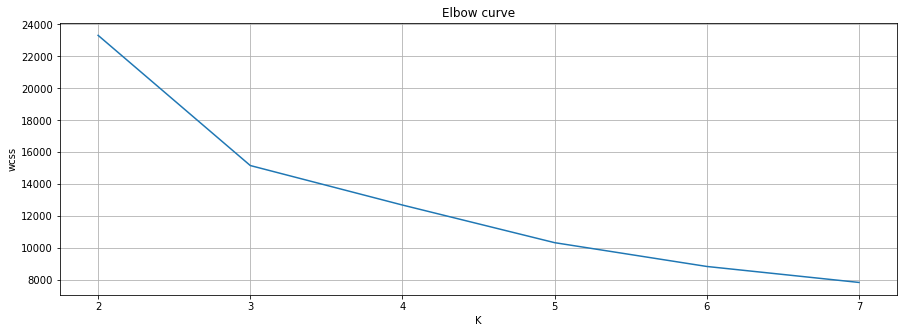

In [148]:
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 8), wcss)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('wcss')
plt.title('Elbow curve');

#### From the above elbow graph we got the number of clusters as 3

In [149]:
k_model=KMeans(n_clusters=3)
y_pred_model=k_model.fit_predict(df_scaled)

In [150]:
from sklearn.metrics import silhouette_score

In [151]:
clust_name=[]
sil_score=[]

In [152]:
silhouette_score(df_scaled,y_pred_model)

0.40192207053261203

In [153]:
clust_name.append('K-means')
sil_score.append(silhouette_score(df_scaled,y_pred_model))

In [154]:
clust_name

['K-means']

In [155]:
df_scaled_dataframe['cluster_label']=y_pred_model

In [156]:
df_scaled_dataframe.head()

,rating,polarity,cluster_label
0,0.856889,1.825639,2
1,0.856889,1.825639,2
2,0.856889,1.825639,2
3,0.856889,1.825639,2
4,0.856889,1.825639,2


In [157]:
df_clust_sel['cluster_label']=y_pred_model

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\917102093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_sel['cluster_label']=y_pred_model


In [158]:
df_clust_sel.head()

,rating_y,polarity_y,cluster_label
0,4.571429,0.42651,2
1,4.571429,0.42651,2
2,4.571429,0.42651,2
3,4.571429,0.42651,2
4,4.571429,0.42651,2


### Made three clusters as Best, Average and Good

In [159]:
fd=df_clust_sel.iloc[:, [0, 1]].values
fd

array([[4.57142857, 0.4265103 ],
       [4.57142857, 0.4265103 ],
       [4.57142857, 0.4265103 ],
       ...,
       [3.8       , 0.18746984],
       [3.8       , 0.18746984],
       [3.8       , 0.18746984]])

In [160]:
np.unique(y_pred_model)

array([0, 1, 2])

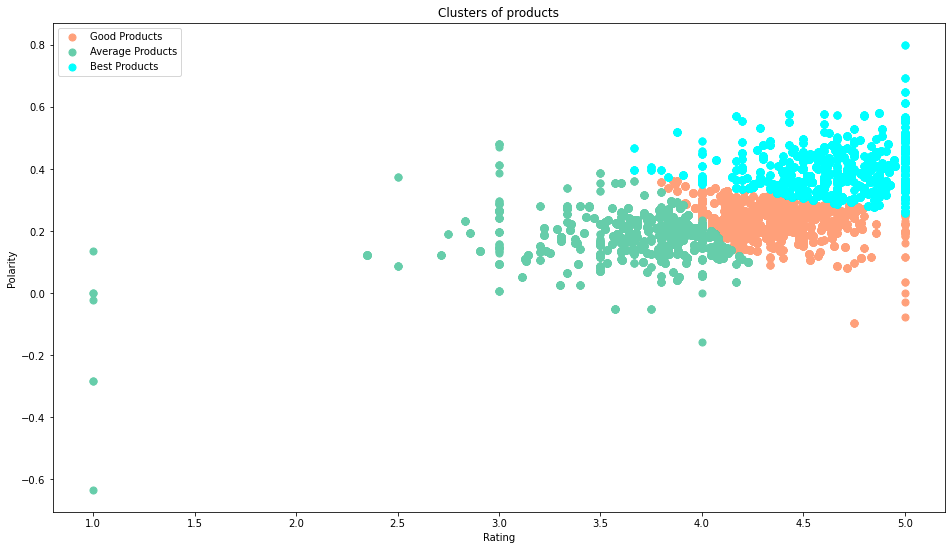

In [161]:
plt.figure(figsize=(16,9))
plt.scatter(fd[y_pred_model == 0, 0], fd[y_pred_model== 0, 1], s = 50, c = '#FFA07A', label = 'Good Products')
plt.scatter(fd[y_pred_model== 1, 0], fd[y_pred_model == 1, 1], s = 50, c = '#66CDAA', label = 'Average Products')
plt.scatter(fd[y_pred_model == 2, 0], fd[y_pred_model== 2, 1], s = 50, c = '#00FFFF', label = 'Best Products')
plt.title('Clusters of products')
plt.xlabel('Rating')
plt.ylabel('Polarity')
plt.legend()
plt.show()

In [162]:
len(y_pred_model)

21272

In [163]:
df_clust['cluster_label']=y_pred_model


In [164]:
df_1=df_clust[['product_id','cluster_label']]
df_1.head()

,product_id,cluster_label
0,B00004U9V2,2
1,B00004U9V2,2
2,B00004U9V2,2
3,B00004U9V2,2
4,B00004U9V2,2


In [165]:
import numpy as np

### Giving the cluster lables to our dataset

In [166]:
df_1['labels']=df_1['cluster_label'].apply(lambda x:'Best products' if x==1 else 'Good products' if x ==2 else 'Average products')

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\2031786868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['labels']=df_1['cluster_label'].apply(lambda x:'Best products' if x==1 else 'Good products' if x ==2 else 'Average products')


In [167]:
df_1

,product_id,cluster_label,labels
0,B00004U9V2,2,Good products
1,B00004U9V2,2,Good products
2,B00004U9V2,2,Good products
3,B00004U9V2,2,Good products
4,B00004U9V2,2,Good products
...,...,...,...
21267,B01DSY86YG,1,Best products
21268,B01DSY86YG,1,Best products
21269,B01DSY86YG,1,Best products
21270,B01DSY86YG,1,Best products


## (ii) Agglomerative

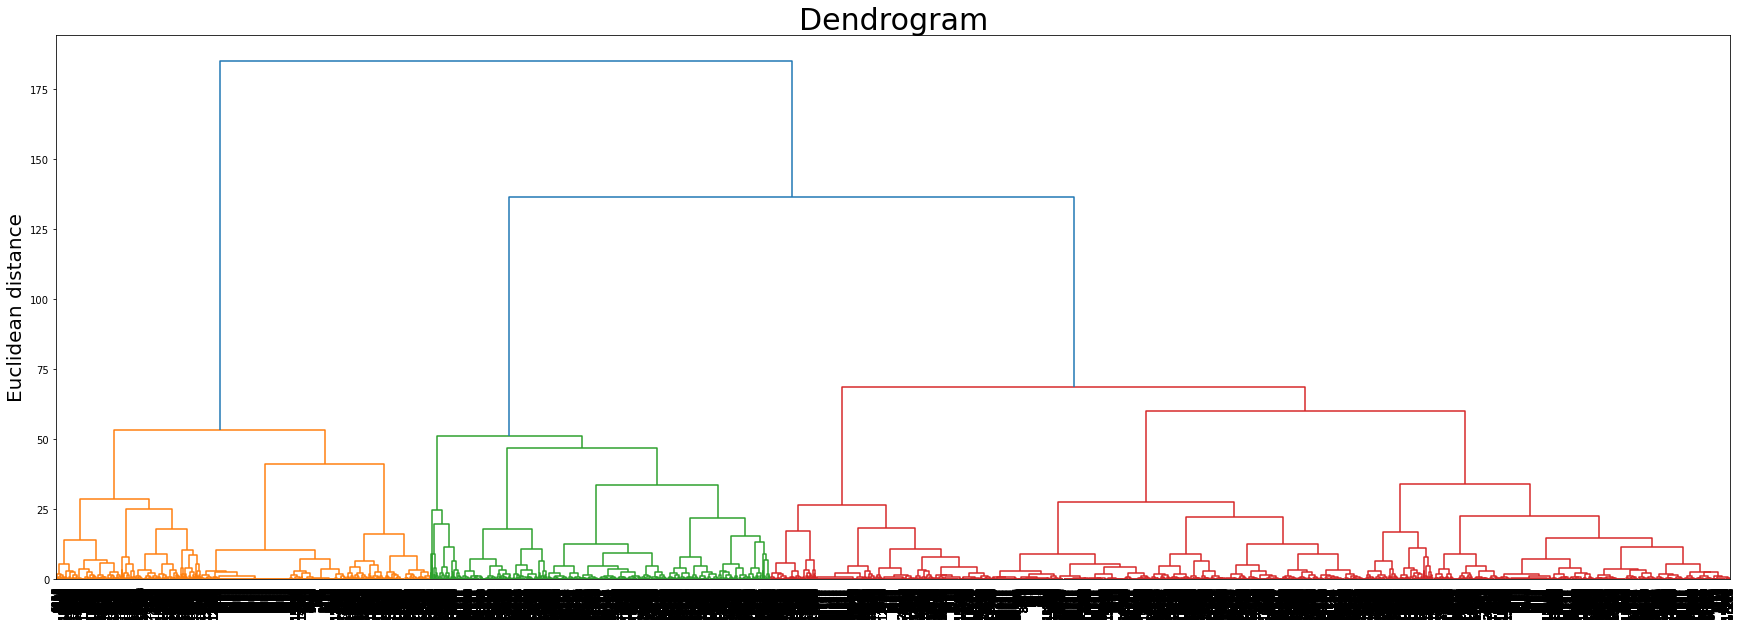

In [168]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(df_scaled, method = 'ward'),labels=df_scaled_dataframe.index)
#plt.axhline(y=12.5, color='r', linestyle='--')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('Dendrogram',fontsize=30)

plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [169]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(df_scaled)

In [170]:
silhouette_score(df_scaled,y_hc)

0.37714379524191327

### Giving the cluster labels to our dataset

In [171]:

df_clust_sel['cluster_label_agglom']=y_hc

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\553158277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_sel['cluster_label_agglom']=y_hc


In [172]:
df_clust_sel.head()

,rating_y,polarity_y,cluster_label,cluster_label_agglom
0,4.571429,0.42651,2,1
1,4.571429,0.42651,2,1
2,4.571429,0.42651,2,1
3,4.571429,0.42651,2,1
4,4.571429,0.42651,2,1


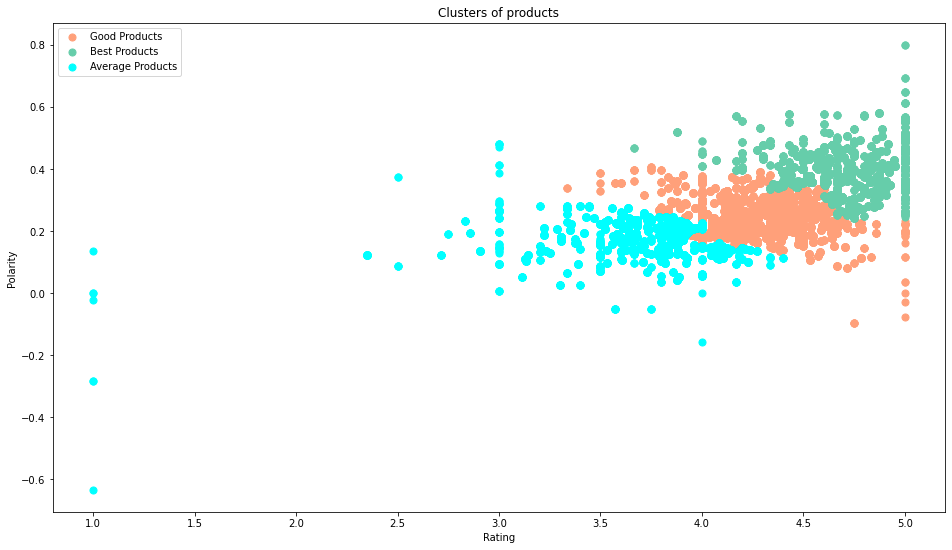

In [173]:
plt.figure(figsize=(16,9))
plt.scatter(fd[y_hc == 0, 0], fd[y_hc== 0, 1], s = 50, c = '#FFA07A', label = 'Good Products')
plt.scatter(fd[y_hc== 1, 0], fd[y_hc == 1, 1], s = 50, c = '#66CDAA', label = 'Best Products')
plt.scatter(fd[y_hc == 2, 0], fd[y_hc== 2, 1], s = 50, c = '#00FFFF', label = 'Average Products')
plt.title('Clusters of products')
plt.xlabel('Rating')
plt.ylabel('Polarity')
plt.legend()
plt.show()

In [174]:
clust_name.append('Agglomerative clustering')
sil_score.append(silhouette_score(df_scaled,y_hc))

In [175]:
clust_name

['K-means', 'Agglomerative clustering']

### Comparision of kmeans with agglomerative

In [176]:
df_comp_clust=pd.DataFrame({"model":clust_name,"silhoutte_score":sil_score})
df_comp_clust

,model,silhoutte_score
0,K-means,0.401922
1,Agglomerative clustering,0.377144


#### Here we found that Kmeans is better

## Customer segmentation :


In [177]:
df_final.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,polarity,blobsentiment
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative
2,2017-04-05,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,Ajaey,True,2017,4,wonderful hand lotion seriously dry skin stay ...,0.346250,Positive
3,2017-03-27,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,3,good hand cream silky thick soak way leave han...,0.306667,Positive
4,2017-02-28,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,5.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,D. Jones,True,2017,2,great hand lotion soak right leave skin super ...,0.519841,Positive


In [178]:
df_rev=df_final.groupby('reviewerID').mean()[['rating','polarity']]
df_rev.reset_index(inplace=True)

### Checking the shape

In [179]:
df_seg_merge=pd.merge(df_final,df_rev,on='reviewerID',how='inner')
df_seg_merge.shape

(21272, 19)

In [180]:
df_seg_merge.head()

,reviewTime,reviewerID,product_id,reviewText,summary,rating_x,main_cat,title,rank_no,price,reviewerName,verified,year,month,final_review,polarity_x,blobsentiment,rating_y,polarity_y
0,2018-01-05,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,4.142857,0.321429
1,2016-08-14,A2HOI48JK8838M,B00004U9V2,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,4324.0,30.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,4.142857,0.321429
2,2017-03-30,A2HOI48JK8838M,B00396VE7U,I was gardening for three hours. No burn. Nice...,Great product.,5.0,Luxury Beauty,Revision Skincare Intellishade SPF 45 Original...,2445.0,75.0,DB,False,2017,3,garden hour no burn nice finished look product...,0.700000,Positive,4.142857,0.321429
3,2018-01-05,A2HOI48JK8838M,B00FASVFI8,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,5.0,Luxury Beauty,Crabtree &amp; Evelyn Ultra-Moisturising Hand ...,60736.0,20.0,DB,True,2018,1,handcream beautiful fragrance not stay protect...,0.483333,Positive,4.142857,0.321429
4,2016-08-14,A2HOI48JK8838M,B00FRERO7G,There is no evidence to me that this product i...,Paying for the name,3.0,Luxury Beauty,Crabtree &amp; Evelyn Gardeners Ultra-Moisturi...,13813.0,24.0,DB,True,2016,8,no evidence product improvement similarly pric...,-0.083333,Negative,4.142857,0.321429


In [181]:
df_clust_sel_a=df_seg_merge[['rating_y','polarity_y']]
df_clust_sel_a.shape

(21272, 2)

### Sacling the data

In [182]:
scaler_a=StandardScaler()

In [183]:
df_scaled_a = scaler.fit_transform(df_clust_sel_a)
df_scaled_a

array([[-0.16507394,  0.37558578],
       [-0.16507394,  0.37558578],
       [-0.16507394,  0.37558578],
       ...,
       [ 1.10001058, -0.89158258],
       [ 1.10001058,  0.73023059],
       [-0.37592137,  1.07988039]])

In [184]:
df_scaled_dataframe_a=pd.DataFrame(df_scaled_a,columns=['rating', 'polarity'])
df_scaled_dataframe_a.head()

,rating,polarity
0,-0.165074,0.375586
1,-0.165074,0.375586
2,-0.165074,0.375586
3,-0.165074,0.375586
4,-0.165074,0.375586


## (i) Kmeans

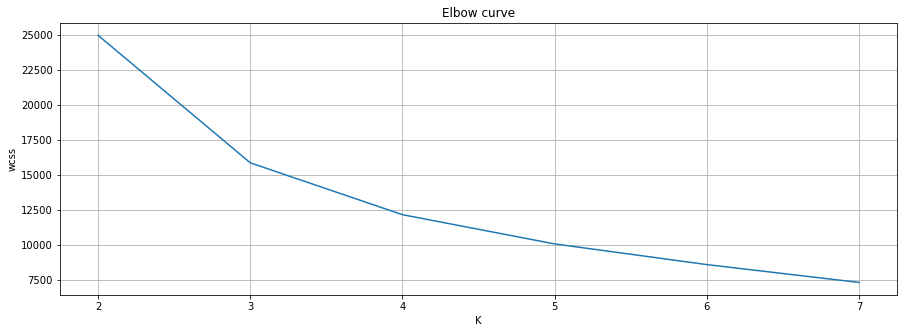

In [185]:
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled_a)
    wcss.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 8), wcss)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('wcss')
plt.title('Elbow curve');

#### From the elbow graph method we got no of clusters as 3

In [186]:
k_model_a=KMeans(n_clusters=3)
y_pred_model_a=k_model_a.fit_predict(df_scaled_a)

In [187]:
silhouette_score(df_scaled_a,y_pred_model_a)

0.4266421817434786

In [188]:
md_name=[]
si_score=[]

In [189]:
md_name.append('k-means')
si_score.append(silhouette_score(df_scaled_a,y_pred_model_a))

In [190]:
si_score

[0.4266421817434786]

In [191]:
md_name

['k-means']

In [192]:
df_clust_sel_a.head()

,rating_y,polarity_y
0,4.142857,0.321429
1,4.142857,0.321429
2,4.142857,0.321429
3,4.142857,0.321429
4,4.142857,0.321429


### Making the clusters 

In [193]:
df_clust_sel_a['cluster_label']=y_pred_model_a

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\3450533625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust_sel_a['cluster_label']=y_pred_model_a


In [194]:
fd_1=df_clust_sel_a.iloc[:, [0, 1]].values
fd_1

array([[4.14285714, 0.32142857],
       [4.14285714, 0.32142857],
       [4.14285714, 0.32142857],
       ...,
       [5.        , 0.12008929],
       [5.        , 0.37777778],
       [4.        , 0.43333333]])

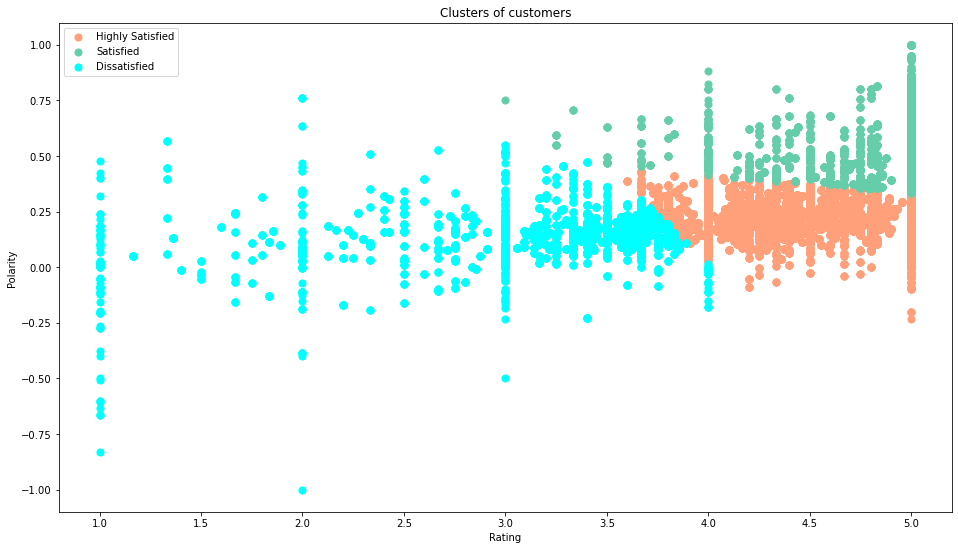

In [195]:
plt.figure(figsize=(16,9))
plt.scatter(fd_1[y_pred_model_a == 0, 0], fd_1[y_pred_model_a== 0, 1], s = 50, c = '#FFA07A', label = 'Highly Satisfied')
plt.scatter(fd_1[y_pred_model_a== 1, 0], fd_1[y_pred_model_a == 1, 1], s = 50, c = '#66CDAA', label = 'Satisfied')
plt.scatter(fd_1[y_pred_model_a == 2, 0], fd_1[y_pred_model_a== 2, 1], s = 50, c = '#00FFFF', label = 'Dissatisfied')
plt.title('Clusters of customers')
plt.xlabel('Rating')
plt.ylabel('Polarity')
plt.legend()
plt.show()

### Assigning the cluster label to our dataset

In [196]:
df_seg_merge['cluster_label']=y_pred_model_a

In [197]:
df_2=df_seg_merge[['reviewerID','cluster_label']]
df_2

,reviewerID,cluster_label
0,A2HOI48JK8838M,0
1,A2HOI48JK8838M,0
2,A2HOI48JK8838M,0
3,A2HOI48JK8838M,0
4,A2HOI48JK8838M,0
...,...,...
21267,A1YLRQL1XZBKCS,2
21268,A1S7TXHM2VM5EF,0
21269,A1S7TXHM2VM5EF,0
21270,A20W9PSUAKDRN1,1


In [198]:
df_2['labels']=df_2['cluster_label'].apply(lambda x:'Dissatisfied customers' if x==1 else 'Highly Satisfied customers' if x ==2 else 'Satisfied')

C:\Users\Asus\AppData\Local\Temp\ipykernel_6148\949955141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['labels']=df_2['cluster_label'].apply(lambda x:'Dissatisfied customers' if x==1 else 'Highly Satisfied customers' if x ==2 else 'Satisfied')


In [199]:
df_2

,reviewerID,cluster_label,labels
0,A2HOI48JK8838M,0,Satisfied
1,A2HOI48JK8838M,0,Satisfied
2,A2HOI48JK8838M,0,Satisfied
3,A2HOI48JK8838M,0,Satisfied
4,A2HOI48JK8838M,0,Satisfied
...,...,...,...
21267,A1YLRQL1XZBKCS,2,Highly Satisfied customers
21268,A1S7TXHM2VM5EF,0,Satisfied
21269,A1S7TXHM2VM5EF,0,Satisfied
21270,A20W9PSUAKDRN1,1,Dissatisfied customers


## (ii) Agglomerative

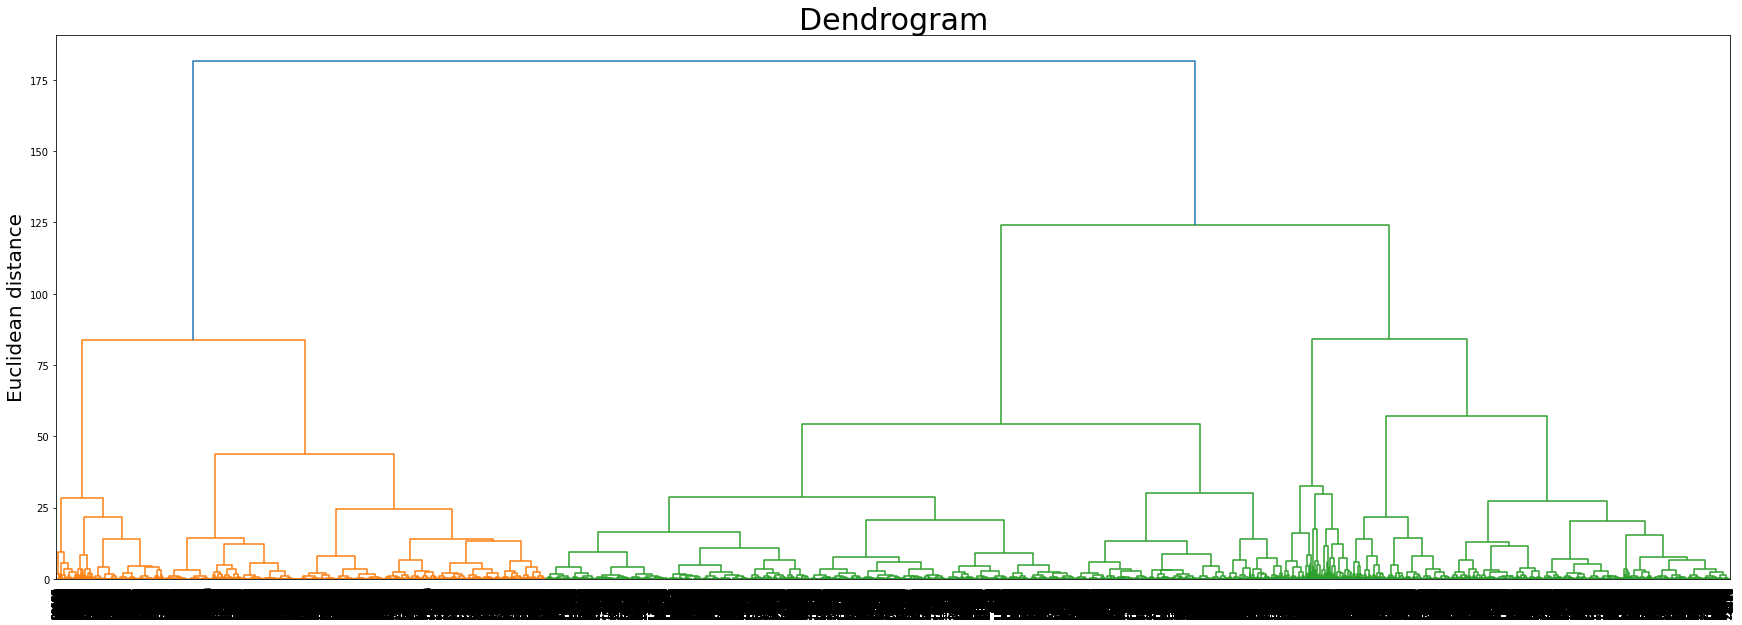

In [200]:
plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(df_scaled_a, method = 'ward'),labels=df_scaled_dataframe_a.index)
#plt.axhline(y=12.5, color='r', linestyle='--')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('Dendrogram',fontsize=30)

plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [201]:
hc_a= AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc_a= hc.fit_predict(df_scaled_a)

In [202]:
md_name.append('agglomerative')
si_score.append(silhouette_score(df_scaled_a,y_hc_a))

In [203]:
md_name

['k-means', 'agglomerative']

In [204]:
si_score

[0.4266421817434786, 0.3385473116045488]

### Comparing the clustering models 

In [205]:
df_comp_clust_agg=pd.DataFrame({"model":md_name,"silhoutte_score":si_score})
df_comp_clust_agg

,model,silhoutte_score
0,k-means,0.426642
1,agglomerative,0.338547


#### Here we got that K means is better

# TIME SERIES ANALYSIS AND SENTIMENT FORECASTING

## Importing the required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

## Reading the first 5 of our data

In [ ]:
df_final.head()

## Checking the columns of our dataframe

In [ ]:
df_final.columns

## Creating a copy of our dataframe

In [ ]:
df_final_p=df_final.copy()

## Setting the reviewTime column as index

In [ ]:
df_final.set_index('reviewTime',inplace=True)

In [ ]:
df_final.head()

## Sorting the index as per their reviewTime

In [ ]:
df_final.sort_index(inplace=True)

In [ ]:
df_final.head()

## Converting the datatype of reviewTime from object to DateTime

In [ ]:
df_final.index=pd.to_datetime(df_final.index)

In [ ]:
df_final.index

In [ ]:
df_final.info()

## Analysis of Positive Negative and Neutral sentiments

## Performing the resampling by Month

In [ ]:
df_positive=df_final[df_final['blobsentiment']=='Positive']
df_negative=df_final[df_final['blobsentiment']=='Negative']
df_neutral=df_final[df_final['blobsentiment']=='Neutral']

In [ ]:
df_positive['product_id'].resample('M').count().plot(figsize=(18,5),label='Positive')
df_negative['product_id'].resample('M').count().plot(figsize=(18,5),label='Negative')
df_neutral['product_id'].resample('M').count().plot(figsize=(18,5),label='Neutral')
plt.legend()
plt.title('Sentiment Trend for Beauty',fontweight='bold')
plt.ylabel('Count of Reviews');
     

#### Here we can see that positive reviews rate is increasing as per the time

In [ ]:
df_positive_re=df_positive['product_id'].resample('M').count()

In [ ]:
df_negative_re=df_negative['product_id'].resample('M').count()

In [ ]:
df_neutral_re=df_neutral['product_id'].resample('M').count()

## Using the decomposition for checking the trend,seasonality and residuals in our data

In [ ]:
# Decomposition plot for predicted data using Features
decomposition_p=seasonal_decompose(df_positive_re, period=12)
d_trend_p=decomposition_p.trend
d_seasonal_p=decomposition_p.seasonal
d_residual_p=decomposition_p.resid
decomposition=seasonal_decompose(df_neutral_re, period=12)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid
decomposition_n=seasonal_decompose(df_negative_re, period=12)
d_trend_n=decomposition_n.trend
d_seasonal_n=decomposition_n.seasonal
d_residual_n=decomposition_n.resid
# plotting all the 4 graphs
fig,ax = plt.subplots(4,3,figsize=(20,12))
plt.subplot(4,3,1)
plt.plot(df_positive_re,label='Positive Sentiment of Reviewers',color='b')
plt.legend(loc='best')
plt.subplot(4,3,2)
plt.plot(df_neutral_re,label='Neutral Sentiment of Reviewers',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,3)
plt.plot(df_negative_re,label='Negative Sentiment of Reviewers',color='g')
plt.legend(loc='best')
plt.subplot(4,3,4)
plt.plot(d_trend_p,label='Positve Trend',color='b')
plt.legend(loc='best')
plt.subplot(4,3,5)
plt.plot(d_trend,label='Neutral Trend',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,6)
plt.plot(d_trend_n,label='Negative Trend',color='g')
plt.legend(loc='best')
plt.subplot(4,3,7)
plt.plot(d_seasonal_p,label='Positve Seasonal',color='b')
plt.legend(loc='best')
plt.subplot(4,3,8)
plt.plot(d_seasonal,label='Neutral Seasonal',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,9)
plt.plot(d_seasonal_n,label='Negative Seasonal',color='g')
plt.legend(loc='best')
plt.subplot(4,3,10)
plt.plot(d_residual_p,label='Positve Residual',color='b')
plt.legend(loc='best')
plt.subplot(4,3,11)
plt.plot(d_residual,label='Neutral Residual',color='orange')
plt.legend(loc='best')
plt.subplot(4,3,12)
plt.plot(d_residual_n,label='Negative Residual',color='g')
plt.legend(loc='best')
plt.suptitle('Decomposition',x=0.5,y=1.05,fontweight='bold',fontsize=20)
plt.tight_layout()
     


## Defining a function to check the stationarity of our data

In [ ]:
# dickey-fuller test for stationarity
# dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    '''
    output:-> 
    1) test statistic, 
    2) p-value, 
    3) number of lags, 
    4) total observations
    
    dfoutput = pd.Series(result[0:4],index=['tstat','pvalue','lags','obs'])
    pvalue = dfoutput['pvalue']
    '''
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

### Checking for the Positive 

In [ ]:
print(checkStationarity(df_positive_re))

In [ ]:
df_pd=pd.DataFrame(df_positive_re)

In [ ]:
from statsmodels.tsa.statespace.tools import diff

In [ ]:
# difference the data by 2
df_pd['diff_1'] = diff(df_pd['product_id'],k_diff=2) #d = 2

In [ ]:
# check if the difference data is stationary
checkStationarity(df_pd['diff_1'].dropna())

In [ ]:
df_pd.head()

### Checking for the Negative

In [ ]:
print(checkStationarity(df_negative_re))

In [ ]:
df_nd=pd.DataFrame(df_negative_re)

In [ ]:
# difference the data by 1
df_nd['diff_1'] = diff(df_nd['product_id'],k_diff=1) #d = 1

In [ ]:
# check if the difference data is stationary
checkStationarity(df_nd['diff_1'].dropna())

### Checking for the Neutral

In [ ]:
print(checkStationarity(df_neutral_re))

In [ ]:
df_ne=pd.DataFrame(df_neutral_re)

In [ ]:
# difference the data by 1
df_ne['diff_1'] = diff(df_ne['product_id'],k_diff=1) #d = 1

In [ ]:
# check if the difference data is stationary
checkStationarity(df_ne['diff_1'].dropna())

## Finding the autocorrelation(q) and partial_autocorrelation(p) values for our models

In [ ]:
fig,ax=plt.subplots(3,2,figsize=(15,15))
plot_acf(df_pd['diff_1'].dropna(),lags=20,ax=ax[0,0])
plot_pacf(df_pd['diff_1'].dropna(),lags=20,ax=ax[0,1])
ax[0,0].set_title('positive auto correlation')
ax[0,1].set_title('positive partial autocorrelation')
plot_acf(df_ne['diff_1'].dropna(),lags=20,ax=ax[1,0])
plot_pacf(df_ne['diff_1'].dropna(),lags=20,ax=ax[1,1])
ax[1,0].set_title('neutral auto correlation')
ax[1,1].set_title('neutral partial auto correlation')
plot_acf(df_nd['diff_1'].dropna(),lags=20,ax=ax[2,0])
plot_pacf(df_nd['diff_1'].dropna(),lags=20,ax=ax[2,1])
ax[2,0].set_title('negative auto correlation')
ax[2,1].set_title('negative partial auto correlation')
plt.show()
     

for positive sentiments : q=1,p=5,d=2

for neutral sentiments : q=1,p=2,d=1

for negative sentiments : q=1,p=2,d=1

## Building the Models :

## ARIMA Model

### For Positive Sentiments

In [ ]:
df_pd.drop('diff_1',axis=1,inplace=True)

In [ ]:
ss = int(0.9 * len(df_pd))

train = df_pd.iloc[:ss]
test = df_pd.iloc[ss:]
print("train = {}, test = {}".format(len(train), len(test)))

In [ ]:
train.head()

In [ ]:
def ljung_box(a):
    pvalue = sm.stats.acorr_ljungbox(a.resid,lags=[1],return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print("Reject H0. Bad model")
    else:
        print("Fail-to-Reject H0. Good model")

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff
# pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
for i in range(1,6):
    for j in range(1,3):
        for k in range(1,3):
            m1 = ARIMA(train,order=(i,k,j)).fit()
            print(f"aic is {m1.aic} and bic is {m1.bic} for model with p,d and q as {i},{k} and {j}")
            ljung_box(m1)
            print("-------------------------------------------------------------------------")                    

p,d,q=5,1,2 for [positve] as we got the lower AIC score for these values

### Model Building For Positive Sentiments

In [ ]:
model_arima=ARIMA(train,order=(5,1,2)).fit()
print(model_arima.summary())

In [ ]:
train.tail()

In [ ]:
test.head()

### Doing the Prediction for Positive Sentiments

In [ ]:
start=len(train)
end=len(train)+len(test)-1
print(start,end)
predictions = model_arima.predict(start,end)
print(predictions)

In [ ]:
test['pred']=predictions

In [ ]:
test['error']=test['product_id']-test['pred']

In [ ]:
mse1 = mean_squared_error(test.product_id,test.pred)
print(f"rmse value is {np.sqrt(mse1)}")

In [ ]:
test.product_id.plot(figsize=(10,8),legend=True)
test.pred.plot(legend=True)
test['error'].plot(legend=True)
plt.title(f"arima model order {5},{1},{2}")

### For Neutral Sentiments

for neutral--q=1,p=2,d=1

In [ ]:
df_ne.drop('diff_1',axis=1,inplace=True)

In [ ]:
ss = int(0.7 * len(df_ne))

train_ne = df_ne.iloc[:ss]
test_ne = df_ne.iloc[ss:]
print("train = {}, test = {}".format(len(train_ne), len(test_ne)))

In [ ]:
for i in range(1,4):
    for j in range(1,3):
        for k in range(1,3):
            m2 = ARIMA(train_ne,order=(i,k,j)).fit()
            print(f"aic is {m2.aic} and bic is {m2.bic} for model with p,d and q as {i},{k} and {j}")
            ljung_box(m2)
            print("-------------------------------------------------------------------------")  

p,d,q=1,1,2 for [neutral] as we got the lower AIC score for these values

### Model Building For Neutral Sentiments

In [ ]:
model_arima_ne=ARIMA(train_ne,order=(1,1,2)).fit()
print(model_arima_ne.summary())

In [ ]:
test_ne.tail()

In [ ]:
train_ne.tail()

### Doing the Prediction for Neutral Sentiments

In [ ]:
start=len(train_ne)
end=len(train_ne)+len(test_ne)-1
print(start,end)
predictions_ne = model_arima_ne.predict(start,end)
print(predictions_ne)

In [ ]:
test_ne['pred']=predictions_ne

In [ ]:
test_ne['error']=test_ne['product_id']-test_ne['pred']

In [ ]:
mse1 = mean_squared_error(test_ne.product_id,test_ne.pred)
print(f"rmse value is {np.sqrt(mse1)}")

In [ ]:
test_ne.product_id.plot(figsize=(10,8),legend=True)
test_ne.pred.plot(legend=True)
test_ne['error'].plot(legend=True)
plt.title(f"arima model order {1},{1},{2}")

### For Negative Sentiments

In [ ]:
#for negative-q=1,p=2,d=1

In [ ]:
df_nd.drop('diff_1',axis=1,inplace=True)

In [ ]:
ss = int(0.7 * len(df_nd))
train_nd = df_nd.iloc[:ss]
test_nd = df_nd.iloc[ss:]
print("train = {}, test = {}".format(len(train_nd), len(test_nd)))


In [ ]:
for i in range(1,4):
    for j in range(1,3):
        for k in range(1,3):
            m3 = ARIMA(train_nd,order=(i,k,j)).fit()
            print(f"aic is {m3.aic} and bic is {m3.bic} for model with p,d and q as {i},{k} and {j}")
            ljung_box(m3)
            print("-------------------------------------------------------------------------")  

p,d,q=1,2,2 for [negative] as we got the lower AIC score for these values

### Model Building For Negative Sentiments

In [ ]:
model_arima_nd=ARIMA(train_nd,order=(1,2,2)).fit()
print(model_arima_nd.summary())

### Doing the Prediction for Negative Sentiments

In [ ]:
start=len(train_nd)
end=len(train_nd)+len(test_nd)-1
print(start,end)
predictions_nd = model_arima_nd.predict(start,end)
print(predictions_nd)

In [ ]:
test_nd['pred']=predictions_nd

In [ ]:
test_nd['error']=test_nd['product_id']-test_nd['pred']

In [ ]:
mse1 = mean_squared_error(test_nd.product_id,test_nd.pred)
print(f"rmse value is {np.sqrt(mse1)}")

In [ ]:
test_nd.product_id.plot(figsize=(10,8),legend=True)
test_nd.pred.plot(legend=True)
test_nd['error'].plot(legend=True)
plt.title(f"arima model order {1},{2},{2}")

## SARIMAX Model

### For Positive Sentiments

In [ ]:
checkStationarity(d_seasonal_p)

### Plotting the graph for finding the value of p and q

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
plot_acf(d_seasonal_p,lags=20,ax=ax[0])  
plot_pacf(d_seasonal_p,lags=20,ax=ax[1])  
plt.show()

We found D=0,P=0,Q=0

### Model Building

In [ ]:
model_sarima_p = SARIMAX(train, order=(5,2,1), seasonal_order=(0,0,0,12)).fit()
print(model_sarima_p.summary())

In [ ]:
test.head()

In [ ]:
test.tail(1)

### Doing the Prediction

In [ ]:
start=len(train)
end=len(train)+len(test)-1
print(start,end)
predictions_sarima = model_sarima_p.predict(start,end)
print(predictions_sarima)

In [ ]:
test['pred_sarima']=predictions_sarima

In [ ]:
test['error_sarima']=test['product_id']-test['pred_sarima']

In [ ]:
mse_sarima = mean_squared_error(test.product_id,test.pred_sarima)
print(f"rmse value is {np.sqrt(mse_sarima)}")

In [ ]:
test.product_id.plot(figsize=(10,8),legend=True)
test.pred_sarima.plot(legend=True)
test['error_sarima'].plot(legend=True)
plt.title(f"sarima model order {5},{2},{1},{0},{0},{0},{12}")

### For Negative Sentiments


In [ ]:
#negative
checkStationarity(d_seasonal_n)

### Plotting the graph for finding the value of p and q

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
plot_acf(d_seasonal_n,lags=20,ax=ax[0])  
plot_pacf(d_seasonal_n,lags=20,ax=ax[1])  
plt.show()

We found P=0,D=0,Q=0

### Model Building

In [ ]:
model_sarima_nd = SARIMAX(train_nd, order=(2,1,1), seasonal_order=(0,0,0,12)).fit()
print(model_sarima_nd.summary())

In [ ]:
print(test_nd.head(2))
print(test_nd.tail(2))

### Doing the Prediction

In [ ]:
start=len(train_nd)
end=len(train_nd)+len(test_nd)-1
print(start,end)
predictions_sarima_nd = model_sarima_nd.predict(start,end)
print(predictions_sarima_nd)

In [ ]:
test_nd.head()

In [ ]:
test_nd['pred_sarima']=predictions_sarima_nd

In [ ]:
test_nd['error_sarima']=test_nd['product_id']-test_nd['pred_sarima']

In [ ]:
mse_sarima_nd = mean_squared_error(test_nd.product_id,test_nd.pred_sarima)
print(f"rmse value is {np.sqrt(mse_sarima_nd)}")

In [ ]:
test_nd.head()

In [ ]:
test_nd.product_id.plot(figsize=(10,8),legend=True)
test_nd.pred_sarima.plot(legend=True)
test_nd['error_sarima'].plot(legend=True)
plt.title(f"sarima model order {2},{1},{1},{0},{0},{0},{12}")

### For Neutral Sentiments

In [ ]:
#neutral
checkStationarity(d_seasonal)

### Plotting the graph for finding the value of p and q

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
plot_acf(d_seasonal_p,lags=20,ax=ax[0])  
plot_pacf(d_seasonal_p,lags=20,ax=ax[1])  
plt.show()

We got P=0,Q=0,D=0

In [ ]:
test_ne.head()

### Model Building

In [ ]:
model_sarima_ne = SARIMAX(train_ne, order=(2,1,1), seasonal_order=(0,0,0,12)).fit()
print(model_sarima_ne.summary())

In [ ]:
print(test_ne.head(2))
print(test_ne.tail(2))

### Doing Prediction

In [ ]:
start=len(train_ne)
end=len(train_ne)+len(test_ne)-1
print(start,end)
predictions_sarima_ne= model_sarima_ne.predict(start,end)
print(predictions_sarima_ne)

In [ ]:
test_ne['pred_sarima']=predictions_sarima_ne

In [ ]:
test_ne['error_sarima']=test_ne['product_id']-test_ne['pred_sarima']

In [ ]:
mse_sarima_ne= mean_squared_error(test_ne.product_id,test_ne.pred_sarima)
print(f"rmse value is {np.sqrt(mse_sarima_ne)}")

In [ ]:
test_ne.head(2)

In [ ]:
test_ne.product_id.plot(figsize=(10,8),legend=True)
test_ne.pred_sarima.plot(legend=True)
test_ne['error_sarima'].plot(legend=True)
plt.title(f"sarima model order {2},{1},{1},{0},{0},{0},{12}")

#### WE ARE USING ARIMA MODEL FOR FORECASTING SINCE IT HAS LOW  RMSE VALUE

## Doing the Forecasting by using our better(ARIMA) model

### For Positive

In [ ]:
test.tail(1)

In [ ]:
df_pd.head()

In [ ]:
fcast = model_arima.predict(start=len(df_pd), end=len(df_pd)+20).rename('forecast')
print(fcast)

In [ ]:
df_pd.plot(figsize=(20,10),legend=True)
fcast.plot(legend=True)

### For Neutral

In [ ]:
fcast_ne = model_arima_ne.predict(start=len(df_ne), end=len(df_ne)+20).rename('forecast')
print(fcast_ne)

In [ ]:
df_ne.plot(figsize=(20,10),legend=True)
fcast_ne.plot(legend=True)

### For Negative

In [ ]:
fcast_nd = model_arima_nd.predict(start=len(df_nd), end=len(df_nd)+20).rename('forecast')
print(fcast_nd)

In [ ]:
df_nd.plot(figsize=(20,10),legend=True)
fcast_nd.plot(legend=True)

#### =>We observe from the forcasting that for the upcoming months the no of positive sentiments for the sold items will gonna increase.